In [211]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

In [212]:
data = pd.read_csv('../data/HSILabel.csv')
data.date = mdates.datestr2num(data.date)
# 決定切割比例為 70%:30%
split_point = int(len(data)*0.7)
# 切割成學習樣本以及測試樣本
train = data.iloc[:split_point,:].copy()
test = data.iloc[split_point:-5,:].copy()

In [213]:
# 訓練樣本再分成目標序列 y 以及因子矩陣 X
train_X = train.drop('week_trend', axis = 1)
train_y = train.week_trend
# 測試樣本再分成目標序列 y 以及因子矩陣 X
test_X = test.drop('week_trend', axis = 1)
test_y = test.week_trend

In [214]:
# 叫出一棵決策樹
model = DecisionTreeClassifier(max_depth = 7)

In [215]:
# 讓 A.I. 學習
model.fit(train_X, train_y)

DecisionTreeClassifier(max_depth=7)

In [216]:
# 讓 A.I. 測驗，prediction 存放了 A.I. 根據測試集做出的預測
prediction = model.predict(test_X)

In [217]:
print(prediction)
num_zeros = (prediction == 0).sum()
num_ones = (prediction == 1).sum()
print(num_zeros)
print(num_ones)

[1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
239
51


In [218]:
test_y

688    0
689    0
690    0
691    0
692    0
      ..
973    1
974    0
975    0
976    1
977    1
Name: week_trend, Length: 290, dtype: int64

In [219]:
confusion_matrix(test_y, prediction)

array([[123,  20],
       [116,  31]], dtype=int64)

In [220]:
model.score(test_X, test_y)

0.5310344827586206

In [221]:
# 計算 ROC 曲線
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, prediction)
# 計算 AUC 面積
auc(false_positive_rate, true_positive_rate)

0.5355121069406783

In [222]:
import pickle

# 儲存模型
filename = 'Decision_Tree_model_001.sav'
pickle.dump(model, open(filename, 'wb'))

# 取出模型
filename = 'Decision_Tree_model_001.sav'
model = pickle.load(open(filename, 'rb'))

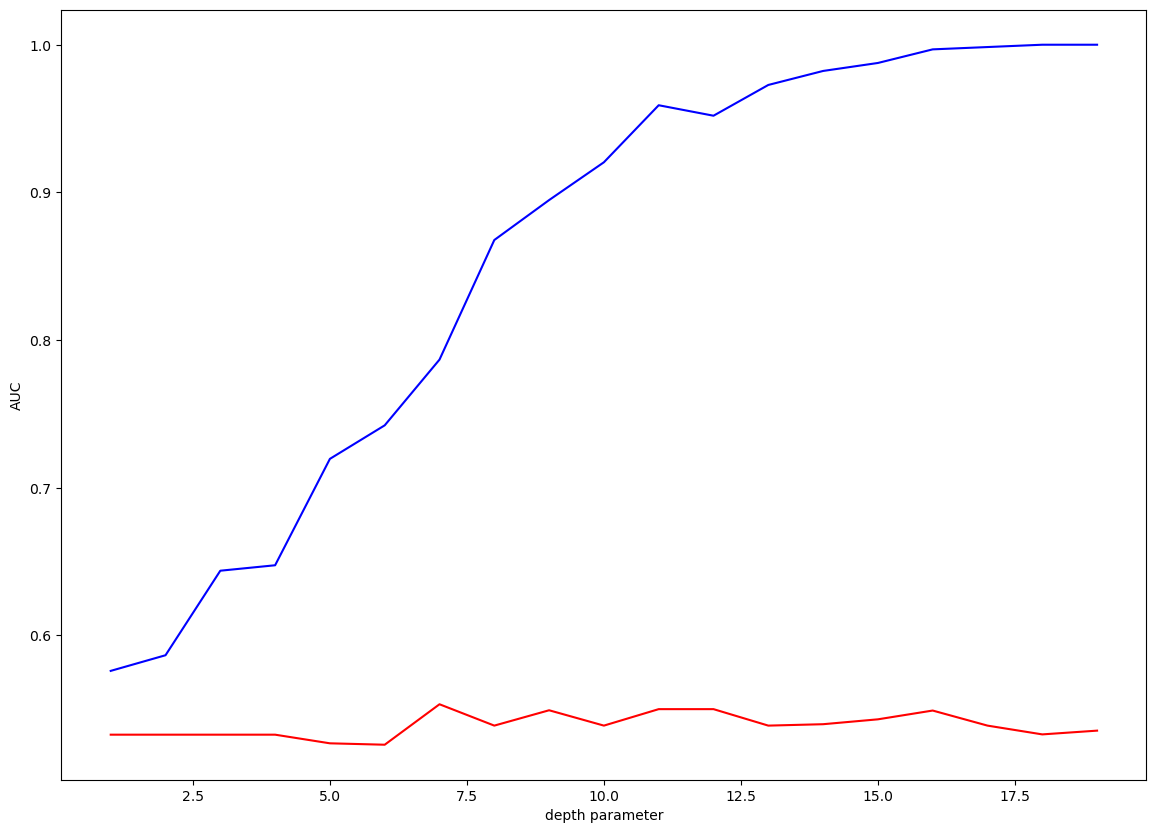

In [223]:
# 測試一批深度參數，一般而言深度不太會超過 3x，我們這邊示範 1 到 50 好了
#depth_parameters = np.arange(1, 50)
depth_parameters = np.arange(1, 20)
# 準備兩個容器，一個裝所有參數下的訓練階段 AUC；另一個裝所有參數下的測試階段 AUC
train_auc= []
test_auc = []
# 根據每一個參數跑迴圈
for test_depth in depth_parameters:
    # 根據該深度參數，創立一個決策樹模型，取名 temp_model
    temp_model = DecisionTreeClassifier(max_depth = test_depth)
    # 讓 temp_model 根據 train 學習樣本進行學習
    temp_model.fit(train_X, train_y)
    # 讓學習後的 temp_model 分別根據 train 學習樣本以及 test 測試樣本進行測驗
    train_predictions = temp_model.predict(train_X)
    test_predictions = temp_model.predict(test_X)
    # 計算學習樣本的 AUC，並且紀錄起來
    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_y, train_predictions)
    auc_area = auc(false_positive_rate, true_positive_rate)
    train_auc.append(auc_area)
    # 計算測試樣本的 AUC，並且紀錄起來
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, test_predictions)
    auc_area = auc(false_positive_rate, true_positive_rate)
    test_auc.append(auc_area)

# 繪圖視覺化
plt.figure(figsize = (14,10))
plt.plot(depth_parameters, train_auc, 'b', label = 'Train AUC')
plt.plot(depth_parameters, test_auc, 'r', label = 'Test AUC')
plt.ylabel('AUC')
plt.xlabel('depth parameter')
plt.show()

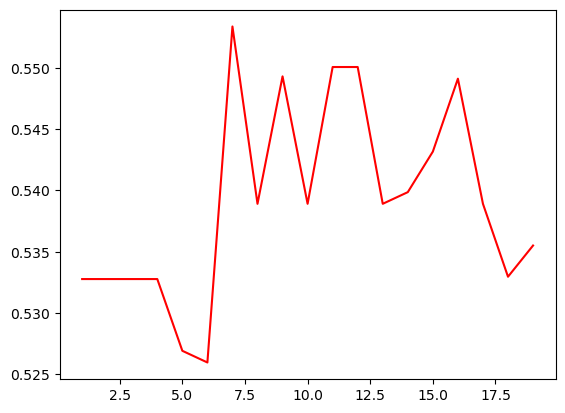

In [224]:
plt.plot(depth_parameters, test_auc, 'r', label = 'Test AUC')

In [225]:
# 叫出一棵決策樹
model = DecisionTreeClassifier(max_depth = 9)

In [226]:
# 讓 A.I. 學習
model.fit(train_X, train_y)

DecisionTreeClassifier(max_depth=9)

In [227]:
# 讓 A.I. 測驗，prediction 存放了 A.I. 根據測試集做出的預測
prediction = model.predict(test_X)

In [228]:
print(prediction)
num_zeros = (prediction == 0).sum()
num_ones = (prediction == 1).sum()
print(num_zeros)
print(num_ones)

[1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
235
55


In [229]:
confusion_matrix(test_y, prediction)

array([[123,  20],
       [112,  35]], dtype=int64)

In [230]:
model.score(test_X, test_y)

0.5448275862068965

In [231]:
# 計算 ROC 曲線
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, prediction)
# 計算 AUC 面積
auc(false_positive_rate, true_positive_rate)

0.5491175491175491

In [232]:
import pickle

# 儲存模型
filename = 'Decision_Tree_model_002.sav'
pickle.dump(model, open(filename, 'wb'))

# 取出模型
filename = 'Decision_Tree_model_001.sav'
model = pickle.load(open(filename, 'rb'))